(ch:aperture)=
# Aperture

In astronomy, [**aperture**](https://en.wikipedia.org/wiki/Aperture) can mean various things. Basically, it is a **hole**. 

In [1]:
# Ignore this cell if you encounter errors
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-20 15:03:27 (KST = GMT+0900) 
0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.12.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.24.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 photutils  1.6.0
8 version_information 1.0.4


In [70]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path
import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

## Simplest Aperture Photometry

### Single-Star

```{admonition} Example
:class: tip
Consider you are observing a single star through this circular hole when seeing FWHM is about 1". You first set this hole to, say, radius 3" and measure the flux. Call it $I_1$. We expect 3" contains almost all flux from this star. Then you increase this hole (say, radius 6") and measure the flux and call it $I_2$. We would expect $I_2 > I_1$ because of the flux from the sky background. The two "holes" are called **"apertures"** in astronomical terms.

If the sky flux is $I_s$ per square arcsec, and the star's flux is $I_0$, we can express $I_1 = I_0 + I_s \pi(3^{\prime\prime})^2$ and $I_2 = I_0 + I_s \pi(6^{\prime\prime})^2$. Thus, 

$$
I_s = \frac{I_2 - I_1}{\pi \left( (6^{\prime\prime})^2 - (3^{\prime\prime})^2 \right)}
$$
and you will be able to obtain $I_0$.
```

The process shown above is the most primitive way of photometry. Let me demonstrate this from python:

In [33]:
# 1. Load data
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])
cut = Cutout2D(ccd, position=(273, 314), size=(100,100))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Inner aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 12.0
Outer aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 24.0
flux at aperture 1 and 2 are 94631.81 and 206870.05
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 82.70
∴ flux0 = 57219.06


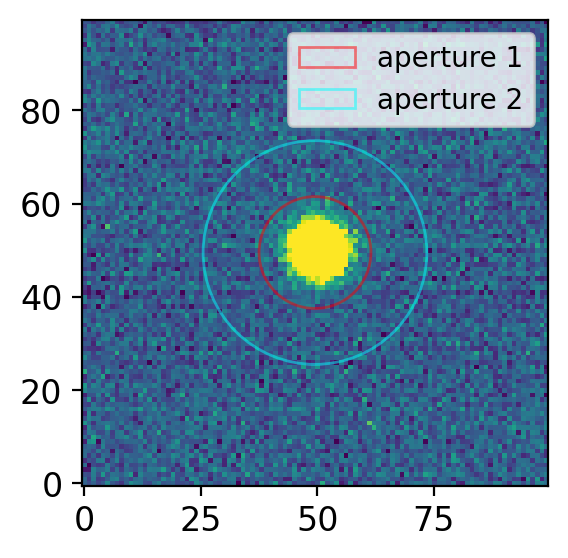

In [66]:
# 2. Set the two "apertures"
ap1 = CircularAperture(positions=cut.center_cutout, r=12)
ap2 = CircularAperture(positions=cut.center_cutout, r=24)
# I used radius 12 and 24 because I know the star is <20 pixels in diameter.
print("Inner aperture:\n", ap1)
print()
print("Outer aperture:\n", ap2)

# 3. Perform photometry
phot = aperture_photometry(cut.data, [ap1, ap2])
flux1 = phot['aperture_sum_0'][0]
flux2 = phot['aperture_sum_1'][0]

# 4. Calculate the sky flux and the total flux
flux_s = (flux2 - flux1) / (ap2.area - ap1.area)
flux0 = flux1 - flux_s * np.pi * 12**2

# 5. Print out the results
print(f"flux at aperture 1 and 2 are {flux1:.2f} and {flux2:.2f}")
print(f"sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = {flux_s:.2f}")
print(f"∴ flux0 = {flux0:.2f}")

# Let me visualize for you
fig, axs = plt.subplots(1, 1, figsize=(3, 4), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs, cut.data, zscale=True)
ap1.plot(color='r', lw=1, alpha=0.5, label="aperture 1")
ap2.plot(color='cyan', lw=1, alpha=0.5, label="aperture 2")
axs.legend(fontsize=10,)
plt.tight_layout()

```{admonition} Example
:class: tip
Now consider you have done this for another star, which has a known magnitude of $m_b = 10$ mag. Say this star is measured to have $I_0 = 50000$. Using Pogson's formula, let's obtain our target's magnitude $m_a$:

$$
m_a - m_b = -2.5 \lg\frac{I_{0, a}}{I_{0, b}} = -2.5 \lg\frac{57219.06}{50000} = -0.146
$$

So $m_a = 9.85$.
```

Before going further, now that you have a basic idea what "aperture" is, please read and practice the tutorial materials given in [photutils/aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html) before proceed further. You have to read
* How to creat `Aperture` object
* How to perfore aperture photometry (including the `method` parameter)
* How to set multiple aperture at a given position

You don't have to read the background subtraction part yet.

### Multiple-Stars

You have learnt how to use DAOFIND in photutils. Let's use it to perform this "simple" photometry to all the field stars.

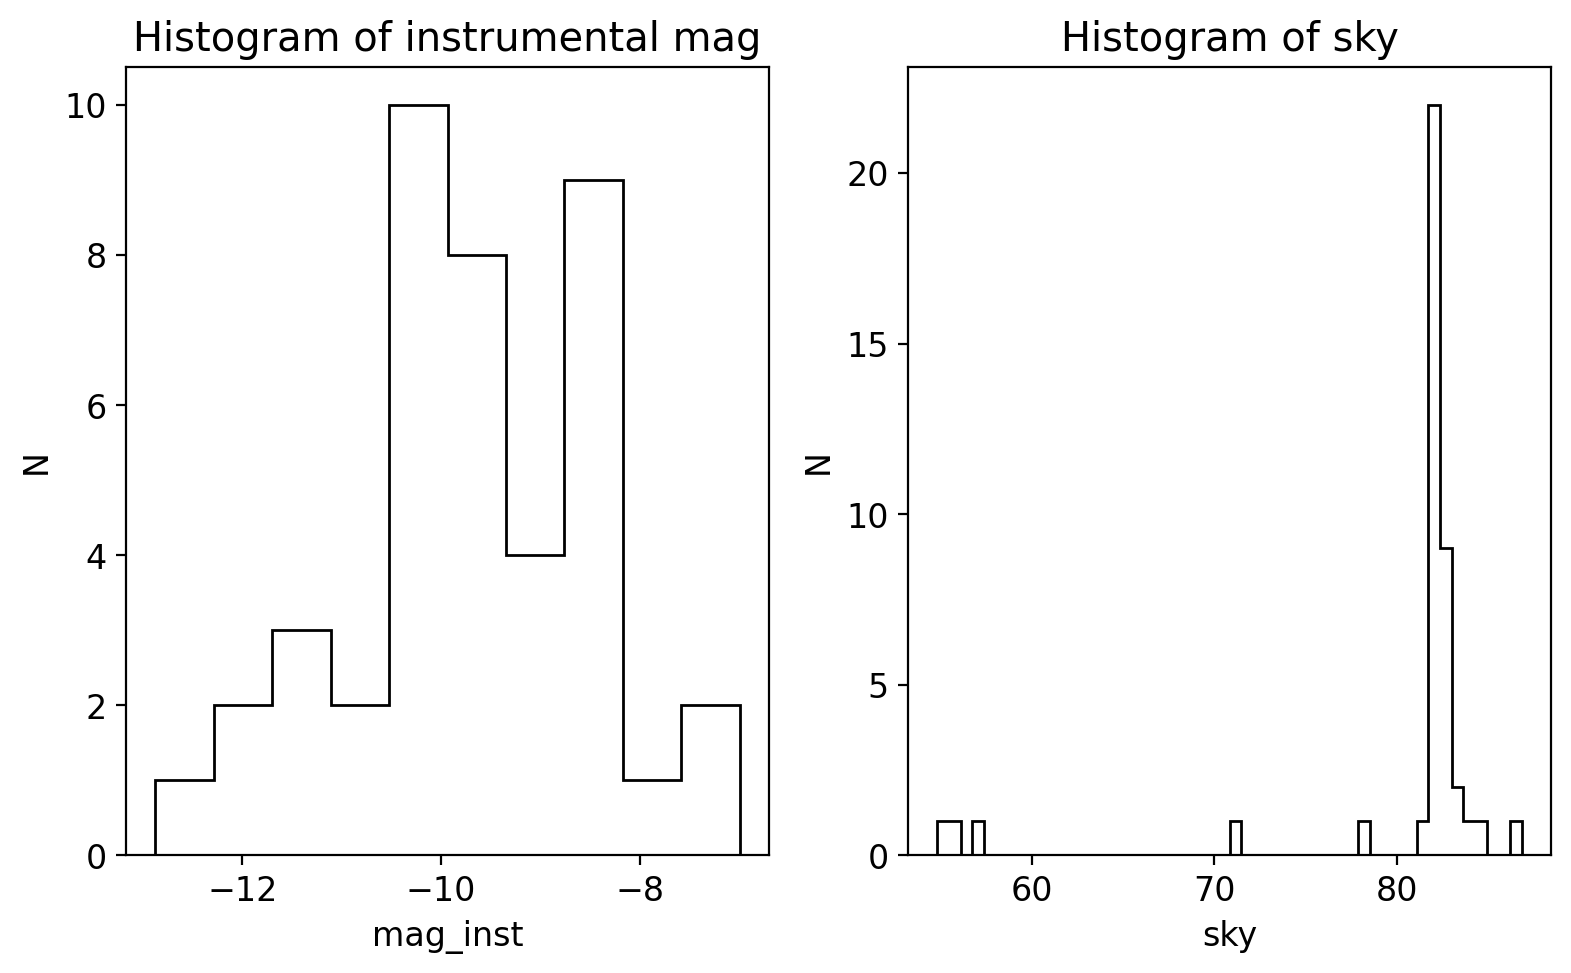

In [69]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(threshold=5.*std, fwhm=4, exclude_border=True) 
sources = finder(ccd.data - med)  

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
aps1 = CircularAperture(pos, r=12)
aps2 = CircularAperture(pos, r=24)
phot = aperture_photometry(ccd.data, [aps1, aps2])
phot["sky"] = (phot['aperture_sum_1'] - phot['aperture_sum_0']) / (aps2.area - aps1.area)
phot["flux"] = phot['aperture_sum_0'] - phot["sky"] * aps1.area
phot["mag"] = -2.5 * np.log10(phot["flux"])
for c in phot.colnames:
    phot[c].info.format = "%.2f" if c!="id" else "%d"

# phot.pprint()
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

#axs[0].
axs[0].hist(phot["mag"], bins=10, histtype="step", lw=1, color="k")
axs[1].hist(phot["sky"], bins=50, histtype="step", lw=1, color="k")
axs[0].set(xlabel="mag_inst", ylabel="N", title="Histogram of instrumental mag")
axs[1].set(xlabel="sky", ylabel="N", title="Histogram of sky")
plt.tight_layout()
plt.show();

Later when you learn how to query online to know the magnitudes of these stars, you can even draw some diagnostic plots of instrumental magnitude and catalog magnitudes. From that analyses, you can determine some parameters such as zero point. Then you can determine the magnitude of the unknown target within the image.

As of photutils 1.4, you can also get basic statistics within aperture (see the [photutils/aperture/aperture statistics](https://photutils.readthedocs.io/en/stable/aperture.html#aperture-statistics) document and the [API reference](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.ApertureStats.html#photutils.aperture.ApertureStats)):

In [80]:
ap_stats = ApertureStats(ccd.data, aps1)
print("Median FWHM of circular 2D Gaussians: ", np.median(ap_stats.fwhm.value))
print("Median ellipticity: ", np.median(ap_stats.ellipticity))

Median FWHM of circular 2D Gaussians:  13.245990971848444
Median ellipticity:  0.01094306912802967


```{admonition} Practice
:class: tip
Read the API reference, test multiple different attributes.
```


Although it is too early to introduce all methods/algorithms regarding photometry, you will soon realize that there are a plethora of different ways to perform photometry. Even for aperture photometry, there is no single "best" way to do it. For finding, DAOFIND is just one possibility that I randomly chose to show you because it is still one of the most widely used algorithm. For aperture photometry, you can use various apertures (elliptical, pill, rectangle, ...) for various scientific purposes. If you are interested in, you may find various ways to improve the accuracy, and the statistically robust ways to determine the flux of a star, etc.